# RQ2 Analysis
This notebook contains the analysis for RQ2. The goal of this analysis is to understand the evolution of the serialization format used in the dataset over the years.

## Select the dataset to analyze

In [392]:
group_under_analysis = 'both'  # change this to 'legacy' or 'recent' to analyze the corresponding dataset

## Load the data
The data is loaded from the `read_repositories_evolution` function, which reads the evolution of repositories from a CSV file. The data contains the commit hash, date, repository URL, and serialization format for each model file in the tree at the time.

In [393]:
from scripts.notebooks.nb_utils import read_repositories_evolution

# model files per repository and the elapsed days between the commit and safetensors' release date
df = read_repositories_evolution(group_under_analysis)
df['year'] = df['date'].dt.year
df['year'] = df['year'].astype(int)  # set year as an integer
df['commit_year_month'] = df['date'].dt.to_period('M')
# exclude undetermined serialization formats
df = df[df['serialization_format'] != 'undetermined']
df = df[df['serialization_format'] != 'UNDETERMINED (symbolic link)']
year_range = list(range(df['year'].min(), df['year'].max() + 1))
df



100%|██████████| 51900/51900 [00:00<00:00, 59924.76commit/s]


,repo_url,commit_hash,model_file_path,serialization_format,message,author,date,is_in_commit,elapsed_days,change_status,year,commit_year_month
0,SidXXD/Pattern_d_0.60_Man_1_Eps_8,9b2be96bb789b1aff091e8ba8e41a5fbeb2705c1,SidXXD/Pattern_d_0.60_Man_1_Eps_8/<v1*>.bin,torch.save,End of training,XideXu,2024-10-23 05:14:58,True,762,*,2024,2024-10
1,SidXXD/Pattern_d_0.60_Man_1_Eps_8,9b2be96bb789b1aff091e8ba8e41a5fbeb2705c1,SidXXD/Pattern_d_0.60_Man_1_Eps_8/pytorch_cust...,torch.save,End of training,XideXu,2024-10-23 05:14:58,True,762,*,2024,2024-10
2,SidXXD/Pattern_d_0.60_Man_1_Eps_8,9b2be96bb789b1aff091e8ba8e41a5fbeb2705c1,SidXXD/Pattern_d_0.60_Man_1_Eps_8/checkpoint-2...,torch.save,End of training,XideXu,2024-10-23 05:14:58,True,762,*,2024,2024-10
3,SidXXD/Pattern_d_0.60_Man_1_Eps_8,9b2be96bb789b1aff091e8ba8e41a5fbeb2705c1,SidXXD/Pattern_d_0.60_Man_1_Eps_8/checkpoint-2...,safetensors,End of training,XideXu,2024-10-23 05:14:58,True,762,*,2024,2024-10
4,SidXXD/Pattern_d_0.60_Man_1_Eps_8,9b2be96bb789b1aff091e8ba8e41a5fbeb2705c1,SidXXD/Pattern_d_0.60_Man_1_Eps_8/checkpoint-2...,safetensors,End of training,XideXu,2024-10-23 05:14:58,True,762,*,2024,2024-10
...,...,...,...,...,...,...,...,...,...,...,...,...
579407,pszemraj/long-t5-tglobal-large-pubmed-3k-books...,95c446c31b2867b2e5f4472630aeaf1faf1e90f5,pszemraj/long-t5-tglobal-large-pubmed-3k-books...,ONNX,add wip15,Peter Szemraj,2022-09-20 17:23:53,True,-2,+,2022,2022-09
579408,pszemraj/long-t5-tglobal-large-pubmed-3k-books...,95c446c31b2867b2e5f4472630aeaf1faf1e90f5,pszemraj/long-t5-tglobal-large-pubmed-3k-books...,torch.save,add wip15,Peter Szemraj,2022-09-20 17:23:53,True,-2,+,2022,2022-09
579409,rufimelo/Legal-BERTimbau-sts-large-ma-v3,24099071e7f31e022b603620f498cb87d6c78a85,rufimelo/Legal-BERTimbau-sts-large-ma-v3/model...,safetensors,Adding `safetensors` variant of this model (#1...,Rui Melo,2024-10-24 16:39:26,True,763,+,2024,2024-10
579410,rufimelo/Legal-BERTimbau-sts-large-ma-v3,24099071e7f31e022b603620f498cb87d6c78a85,rufimelo/Legal-BERTimbau-sts-large-ma-v3/pytor...,torch.save,Adding `safetensors` variant of this model (#1...,Rui Melo,2024-10-24 16:39:26,False,763,,2024,2024-10


## Visualization of serialization format distribution over the years

### Common Configuration

In [405]:
import matplotlib.pyplot as plt
title_suffix = f'({group_under_analysis.capitalize()} Repositories)' if group_under_analysis != 'both' else '(All Repositories)'
color_map = {
    "ONNX": "#1f77b4",
    "h5/hdf5": "#ff7f0e",
    "joblib": "#2ca02c",
    "numpy": "#d62728",
    "pickle": "#9467bd",
    "safetensors": "#8c564b",
    "torch.save": "#e377c2",
}
# Set a different font with broad Unicode support
plt.rcParams['font.family'] = 'DejaVu Sans'
# Decrease padding for y-axis tick labels
plt.rcParams['ytick.major.pad'] = 0  # Decrease this value as needed

### Line Chart Repository-level breakdown
Step by step:
 1. We first group by repo creation date buckets (e.g., month of repo creation)
 2. We compute the first format being used in the repo (we do so by grabbing first commit adding model files, whatever those might be)

The goal is to see whether newer repos adopt it more quickly than older ones.

#### Prepare the data

In [395]:
from nb_utils import extract_metadata
import pandas as pd
repos_metadata = extract_metadata(group_under_analysis)
df['created_at'] = df['repo_url'].map(lambda x: repos_metadata[x]['created_at'])
df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
df['date'] = pd.to_datetime(df['date'], utc=True)
# Notice that 2022-03-02T23:29:04.000Z assigned to all repositories created before HF began storing creation dates.
# so we need to adjust the created_at date to the first commit date if created_at is > the first commit date
# grab date from first commit in repository
df_first_commit = df.sort_values('date').drop_duplicates(['repo_url', 'created_at'], keep='first')
# create map of repo_url to date (commit date)
df_first_commit = df_first_commit[['repo_url', 'date']].set_index('repo_url')
# adjust created_at to the first commit date if created_at is > the first commit date
print(min(df['created_at']), max(df['created_at']))
df['created_at'] = df.apply(lambda row: row['created_at'] if row['created_at'] <= row['date'] else row['date'], axis=1)
print(min(df['created_at']), max(df['created_at']))
# df_first_commit


df['created_at_month_year'] = df['created_at'].dt.tz_localize(None).dt.to_period('M')
# filter by change_status = '+'
df_first_addition_commit = df[df['change_status'] == '+']
# grab first commit adding model files per repo
df_first_addition_commit = df_first_addition_commit.sort_values('date').drop_duplicates(['repo_url', 'created_at'],
                                                                                        keep='first')

# compute the counts of each serialization format per month of repo creation
serialization_format_counts = df_first_addition_commit.groupby(
    ['created_at_month_year', 'serialization_format']).size().unstack(fill_value=0)
# Plotting the distribution using a percentage line chart
serialization_format_counts = serialization_format_counts.div(serialization_format_counts.sum(axis=1), axis=0) * 100
serialization_format_counts

# save the serialization format counts to a CSV file
serialization_format_counts.to_csv(RESULTS_DIR / f'RQ2FormatsRepoCreation_{group_under_analysis}.csv')

2022-03-02 23:29:04+00:00 2024-12-31 09:03:07+00:00
2019-02-06 10:35:15+00:00 2024-12-31 05:46:04+00:00


#### Plotting the data

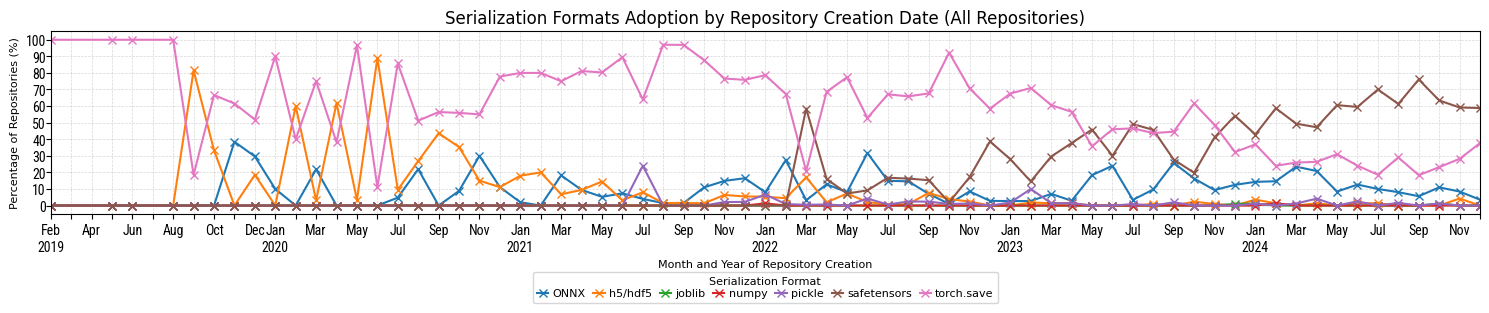

In [408]:
import matplotlib.pyplot as plt
import numpy as np
import calendar
from nb_utils import ROBOTO_CONDENSED_FONT
from nb_utils import RESULTS_DIR
if group_under_analysis == 'both' :
    fig_size = (15, 3.5)
elif group_under_analysis == 'recent' :
    fig_size = (13, 3.5)
else:
    fig_size = (10, 3.5)
# Plotting the distribution using a percentage line chart
ax = serialization_format_counts.plot(kind='line', marker='x', figsize=fig_size, color=color_map)
plt.title(f'Serialization Formats Adoption by Repository Creation Date {title_suffix}')
plt.xlabel('Month and Year of Repository Creation', fontsize=8)
plt.ylabel('Percentage of Repositories (%)', fontsize=8)
xticks = []
xticklabels = []
min_month = serialization_format_counts.index.to_timestamp().to_period('M').unique().min().month
for year in year_range:
    start_month = 1 if year > serialization_format_counts.index.year.min() else min_month
    for month in range(start_month, 13):
        xticks.append("{}-{}".format(year, month))
        if month == start_month:
            xticklabels.append(f"{calendar.month_abbr[month]}\n{year}")
        elif (month - start_month) % 2 == 0:  # Show every 2nd month
            xticklabels.append(calendar.month_abbr[month])
        else:
            xticklabels.append('')  # Empty label for odd months to reduce clutter
        # xticklabels.append(f"{calendar.month_abbr[month]}\n{year}" if month == start_month else calendar.month_abbr[month])
plt.xticks(xticks,  xticklabels, rotation=0, fontsize=8.5, fontproperties=ROBOTO_CONDENSED_FONT)

# add vertical lines for each year
# for year in year_range:
#     plt.axvline(x=f"{year}-01", color='red', linestyle='--', linewidth=0.5)

plt.yticks(np.arange(0, 101, 10), fontsize=8.5, fontproperties=ROBOTO_CONDENSED_FONT)  # Set y-ticks from 0 to 100 with a step of 10
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Add grid lines with light gray color


# Move the legend outside the plot
plt.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=7,
           title_fontsize=8, fontsize=8,
           labelspacing=0.2,  # Reduce vertical space between labels
           handlelength=1.0,  # Shorter line handles
           handletextpad=0.4,  # Less space between handle and text
           borderaxespad=0.3,  # Padding between legend and axes
           borderpad=0.4,  # Padding inside the legend box
           columnspacing=0.7  # Horizontal space between columns (if used)
           )
plt.tight_layout()
# save as pdf
plt.savefig(RESULTS_DIR / f'RQ2FormatsRepoCreation_{group_under_analysis}.pdf', format='pdf', bbox_inches='tight')
plt.show()


### Stacked Bar Chart Repository-level breakdown yearly

#### Prepare the data
For each repository, we want to find the last commit hash per year. If a repository does not have a commit hash for a specific year, we will use the last commit hash from the previous year(s).
We use the last commit hash per year for each repository to obtain the list of files in the tree at that point. THen, we compute the counts of each serialization format per year across all the serialized model files in a repository's tree.
Then we plot the distribution of serialization formats per year, using the last commit hash per year for each repository.

In [397]:
import pandas as pd

# find the last commit hash per repository per year
df_last_hash = df.sort_values('date').drop_duplicates(['repo_url', 'year'], keep='last')
df_last_hash = df_last_hash[['repo_url', 'year', 'commit_hash', 'date']]

# ensure that all repos have one hash a year, if not, use last years'  hash
last_hash_per_repo = {(r['repo_url'], r['year']): r for _, r in df_last_hash.iterrows()}
for repo_url in df['repo_url'].unique():
    for year in year_range:
        key = (repo_url, year)
        if key not in last_hash_per_repo:
            # find the last commit hash from the previous year(s)
            for y in range(year, df['year'].min() - 1, -1):
                if (repo_url, y) in last_hash_per_repo:
                    df_last_hash = pd.concat([df_last_hash, pd.DataFrame({
                        'repo_url': [repo_url],
                        'year': [year],
                        'commit_hash': [last_hash_per_repo[(repo_url, y)]['commit_hash']],
                        'date': [last_hash_per_repo[(repo_url, y)]['date']]
                    })], ignore_index=True)
                    break

df_last_hash[df_last_hash['repo_url'] == 'google-bert/bert-base-chinese']
print("Min date", df_last_hash['date'].min(), "Max date", df_last_hash['date'].max())

# slice the original dataframe to keep only the last commit hash per year
df_slice = df[df.set_index(['repo_url', 'year']).index.isin(df_last_hash.set_index(['repo_url', 'year']).index)]
# compute the counts of each serialization format per year
serialization_format_counts_yearly = df_slice.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)
# normalize the counts to percentages
serialization_format_counts_yearly = serialization_format_counts_yearly.div(
    serialization_format_counts_yearly.sum(axis=1), axis=0) * 100

serialization_format_counts_yearly
# df_slice[(df_slice['year']==2019) & (df_slice['serialization_format'] == 'torch.save')].sort_values('date', ascending=False)

Min date 2019-09-23 15:48:20+00:00 Max date 2024-12-31 12:30:54+00:00


serialization_format,ONNX,h5/hdf5,joblib,numpy,pickle,safetensors,torch.save
year,,,,,,,
2019,13.432836,25.373134,0.000000,0.000000,0.000000,0.000000,61.194030
2020,14.763780,23.425197,0.000000,0.000000,0.000000,0.000000,61.811024
2021,3.903305,2.328676,0.000000,0.000000,20.647594,0.000000,73.120426
2022,10.156065,1.885789,0.000000,0.005912,0.419721,1.862142,85.670371
2023,1.007143,0.119050,0.000869,0.008690,0.067780,74.362606,24.433862
2024,1.876442,0.278289,0.001606,0.021107,0.052308,88.222851,9.547396


#### Plotting the data in a stacked bar chart to 100%

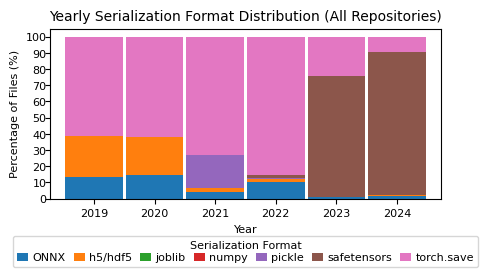

In [398]:
import matplotlib.pyplot as plt

fig_size = (5, 3) if group_under_analysis != 'recent' else (4, 3)
serialization_format_counts_yearly.plot(kind='bar', stacked=True, color=color_map, figsize=fig_size, width=.95)
plt.title(f'Yearly Serialization Format Distribution {title_suffix}', fontsize=10)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Percentage of Files (%)', fontsize=8)
plt.xticks(rotation=0, fontsize=8)
plt.yticks(np.arange(0, 101, 10), fontsize=8)  # Set y-ticks from 0 to 100 with a step of 10

# Move the legend outside the plot
plt.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7,
           title_fontsize=8,  # Smaller font size for the legend title
           fontsize=8,  # Smaller font size for the legend
           labelspacing=0.2,  # Reduce vertical space between labels
           handlelength=1.0,  # Shorter line handles
           handletextpad=0.4,  # Less space between handle and text
           borderaxespad=0.3,  # Padding between legend and axes
           borderpad=0.4,  # Padding inside the legend box
           columnspacing=0.7  # Horizontal space between columns (if used)
           )
plt.tight_layout()
# save as pdf
plt.savefig(RESULTS_DIR / f'RQ2FormatsYearly_{group_under_analysis}.pdf', format='pdf', bbox_inches='tight')
plt.show()